# Time Series Attribution with CRP

This notebook demonstrates how to use Concept Relevance Propagation (CRP) for time series classification models.
We'll analyze a 1D CNN trained on vibration data to understand which temporal patterns and channels (X, Y, Z) contribute to classification decisions.

## Overview
- **Data**: 3-channel vibration time series (shape: [batch, 3, 2000])
- **Model**: 1D CNN for binary classification (good vs bad)
- **Goal**: Understand which time segments and channels are most relevant for predictions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../../zennit-crp')


In [3]:
import gc
import torch


# Before calling your function
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()


0

In [30]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add the CRP modules to path

# Import CRP components
from crp.attribution import CondAttribution
from crp.helper import get_layer_names
from crp.graph import trace_model_graph

# Import our adapted components
from crp.time_series_concepts import TimeSeriesConcept
from crp.time_series_visualization import (
    plot_time_series_with_relevance,
    plot_channel_importance,
    visualize_temporal_concepts
)
from crp.relevance_visualization import *

# Import your model and dataset
from models.cnn1D_model import CNN1D_Wide, VibrationDataset

# Zennit composites for different LRP rules
from zennit.composites import EpsilonGammaBox, EpsilonPlus, EpsilonAlpha2Beta1

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Load Model and Data

In [9]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load trained model
model = CNN1D_Wide()
model.load_state_dict(torch.load('../models/cnn1d_model.ckpt', map_location=device, weights_only=True))
model.to(device)
model.eval()

print("Model loaded successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cuda
Model loaded successfully!
Model parameters: 76,898


In [10]:
# Load dataset
data_dir = "E:/Thesis/Datasets/CNC/data/final/new_selection/normalized_windowed_downsampled_data"

dataset = VibrationDataset(data_dir)

print(f"Dataset size: {len(dataset)}")
print(f"Classes: Good ({sum(dataset.labels == 0)}), Bad ({sum(dataset.labels == 1)})")

# Get a sample for analysis
sample_data, sample_label = dataset[100]  # Choose an interesting sample
sample_data = sample_data.unsqueeze(0).to(device)  # Add batch dimension
sample_data.requires_grad = True

print(f"Sample shape: {sample_data.shape}")
print(f"Sample label: {'Good' if sample_label == 0 else 'Bad'}")

Dataset size: 7501
Classes: Good (5606), Bad (1895)
Sample shape: torch.Size([1, 3, 2000])
Sample label: Good


## 2. Model Analysis Setup

In [11]:
# Get layer names from the model
conv_layer_names = get_layer_names(model, [nn.Conv1d])
linear_layer_names = get_layer_names(model, [nn.Linear])
all_layer_names = conv_layer_names + linear_layer_names

print("Convolutional layers:")
for name in conv_layer_names:
    print(f"  - {name}")
    
print("\nLinear layers:")
for name in linear_layer_names:
    print(f"  - {name}")

# Create layer mapping with TimeSeriesConcept
layer_map = {name: TimeSeriesConcept() for name in all_layer_names}

print(f"\nCreated concept mapping for {len(layer_map)} layers")

Convolutional layers:
  - conv1
  - conv2
  - conv3
  - conv4

Linear layers:
  - fc1
  - fc2

Created concept mapping for 6 layers


In [14]:
# Create model graph for understanding layer connections
graph = trace_model_graph(model, sample_data, all_layer_names)

print("Model graph created successfully!")
print("\nLayer connections:")
for layer_name in conv_layer_names[:4]:  # Show first 3 layers
    input_layers = graph.find_input_layers(layer_name)
    print(f"{layer_name} <- {input_layers}")

Model graph created successfully!

Layer connections:
conv1 <- []
conv2 <- ['conv1']
conv3 <- ['conv2']
conv4 <- ['conv3']


## 3. Initialize Attribution

In [15]:
# Create attribution object
attribution = CondAttribution(model, device)

print("Attribution object created!")
print(f"Model device: {attribution.device}")

Attribution object created!
Model device: cuda


## 4. Basic Attribution Analysis

Let's start with a simple attribution to understand which input time points are most relevant for the prediction.

In [16]:
# Get model prediction first
with torch.no_grad():
    prediction = model(sample_data)
    predicted_class = torch.argmax(prediction, dim=1)
    confidence = torch.softmax(prediction, dim=1)

print(f"Prediction: {prediction}")
print(f"Predicted class: {'Good' if predicted_class == 0 else 'Bad'}")
print(f"Confidence: Good={confidence[0,0]:.3f}, Bad={confidence[0,1]:.3f}")

Prediction: tensor([[ 3.6578, -6.9470]], device='cuda:0')
Predicted class: Good
Confidence: Good=1.000, Bad=0.000


In [17]:
# Define different LRP rules to compare
composites = {
    'Epsilon-Gamma': EpsilonGammaBox(low=-1, high=1, gamma=0.25),
    'Epsilon-Plus': EpsilonPlus(),
    'Alpha-Beta': EpsilonAlpha2Beta1()
}

# Simple attribution: analyze prediction with respect to predicted class
conditions = [{'y': [predicted_class.item()]}]  # 'y' refers to model output

results = {}
for rule_name, composite in composites.items():
    print(f"Computing attribution with {rule_name}...")
    result = attribution(sample_data, conditions, composite)
    results[rule_name] = result
    print(f"  Heatmap shape: {result.heatmap.shape}")
    print(f"  Heatmap range: [{result.heatmap.min():.4f}, {result.heatmap.max():.4f}]")

Computing attribution with Epsilon-Gamma...
  Heatmap shape: torch.Size([1, 2000])
  Heatmap range: [-0.0056, 0.0419]
Computing attribution with Epsilon-Plus...
  Heatmap shape: torch.Size([1, 2000])
  Heatmap range: [-0.0021, 0.0426]
Computing attribution with Alpha-Beta...
  Heatmap shape: torch.Size([1, 2000])
  Heatmap range: [-0.0139, 0.1122]


E:\Thesis\crp_cloned_new\zennit-crp\.crp_new\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


## 5. Layer-wise Attribution Analysis

Now let's analyze specific layers to understand what concepts they learn.

In [21]:
# Analyze first convolutional layer concepts
layer_to_analyze = conv_layer_names[0]  # First conv layer
print(f"Analyzing layer: {layer_to_analyze}")

# Get layer output shape for understanding
with torch.no_grad():
    # Forward pass to get intermediate activations
    handles = []
    layer_outputs = {}
    
    def get_activation(name):
        def hook(model, input, output):
            layer_outputs[name] = output.detach()
        return hook
    
    # Register hook
    for name, module in model.named_modules():
        if name == layer_to_analyze:
            handle = module.register_forward_hook(get_activation(name))
            handles.append(handle)
    
    _ = model(sample_data)
    
    # Remove hooks
    for handle in handles:
        handle.remove()

layer_output = layer_outputs[layer_to_analyze]
print(f"Layer output shape: {layer_output.shape}")
print(f"Number of channels/concepts: {layer_output.shape[1]}")

Analyzing layer: conv1
Layer output shape: torch.Size([1, 16, 2000])
Number of channels/concepts: 16


In [23]:
# Analyze specific channels/concepts in the layer
num_channels = layer_output.shape[1]
channels_to_analyze = list(range(min(6, num_channels)))  # Analyze first 6 channels

print(f"Analyzing channels: {channels_to_analyze}")

# Create conditions for each channel - INCLUDE model output
predicted_class_item = predicted_class.item()
channel_conditions = [
    {layer_to_analyze: [ch], 'y': [predicted_class_item]}
    for ch in channels_to_analyze
]

# Use Epsilon-Gamma rule for this analysis
composite = EpsilonGammaBox(low=-1, high=1, gamma=0.25)

# Compute attribution for each channel
channel_results = []
for i, condition in enumerate(channel_conditions):
    print(f"Computing attribution for channel {channels_to_analyze[i]}...")
    result = attribution(sample_data, [condition], composite, 
                        record_layer=[layer_to_analyze])
    channel_results.append(result)
    
print("Channel-wise attribution complete!")

Analyzing channels: [0, 1, 2, 3, 4, 5]
Computing attribution for channel 0...
Computing attribution for channel 1...
Computing attribution for channel 2...
Computing attribution for channel 3...
Computing attribution for channel 4...
Computing attribution for channel 5...
Channel-wise attribution complete!


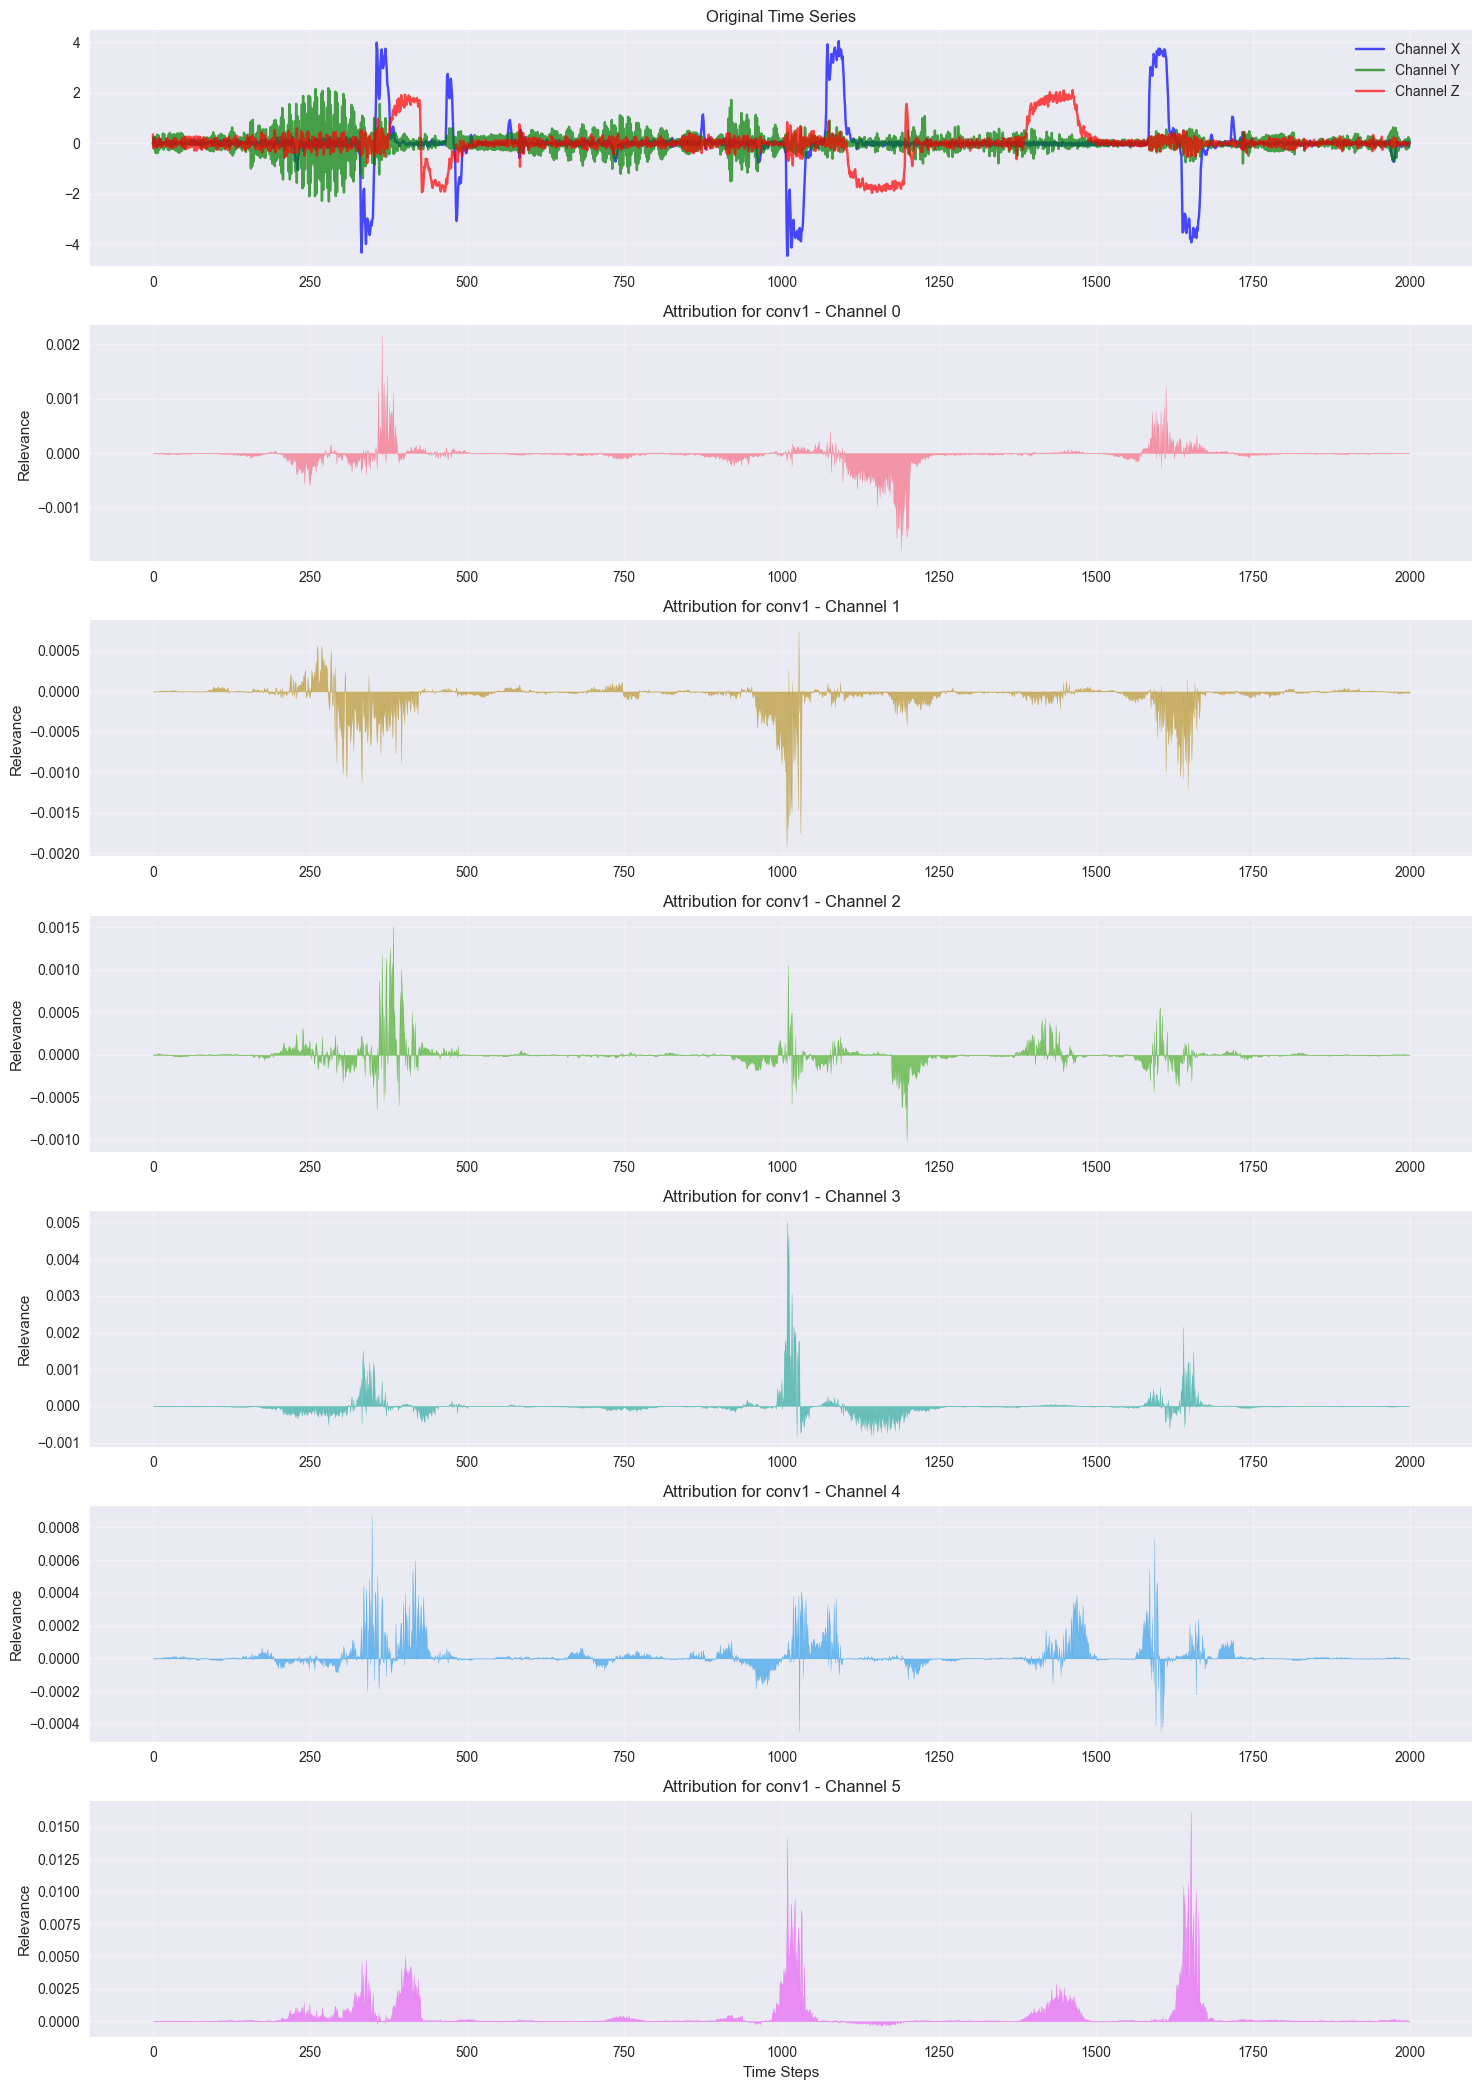

In [24]:
# Visualize channel-wise attributions
visualize_with_label_attribution(sample_data, channel_results, label, "LRP/Time")


## 6. Concept Activation Analysis

Activations shape: torch.Size([1, 16, 2000])


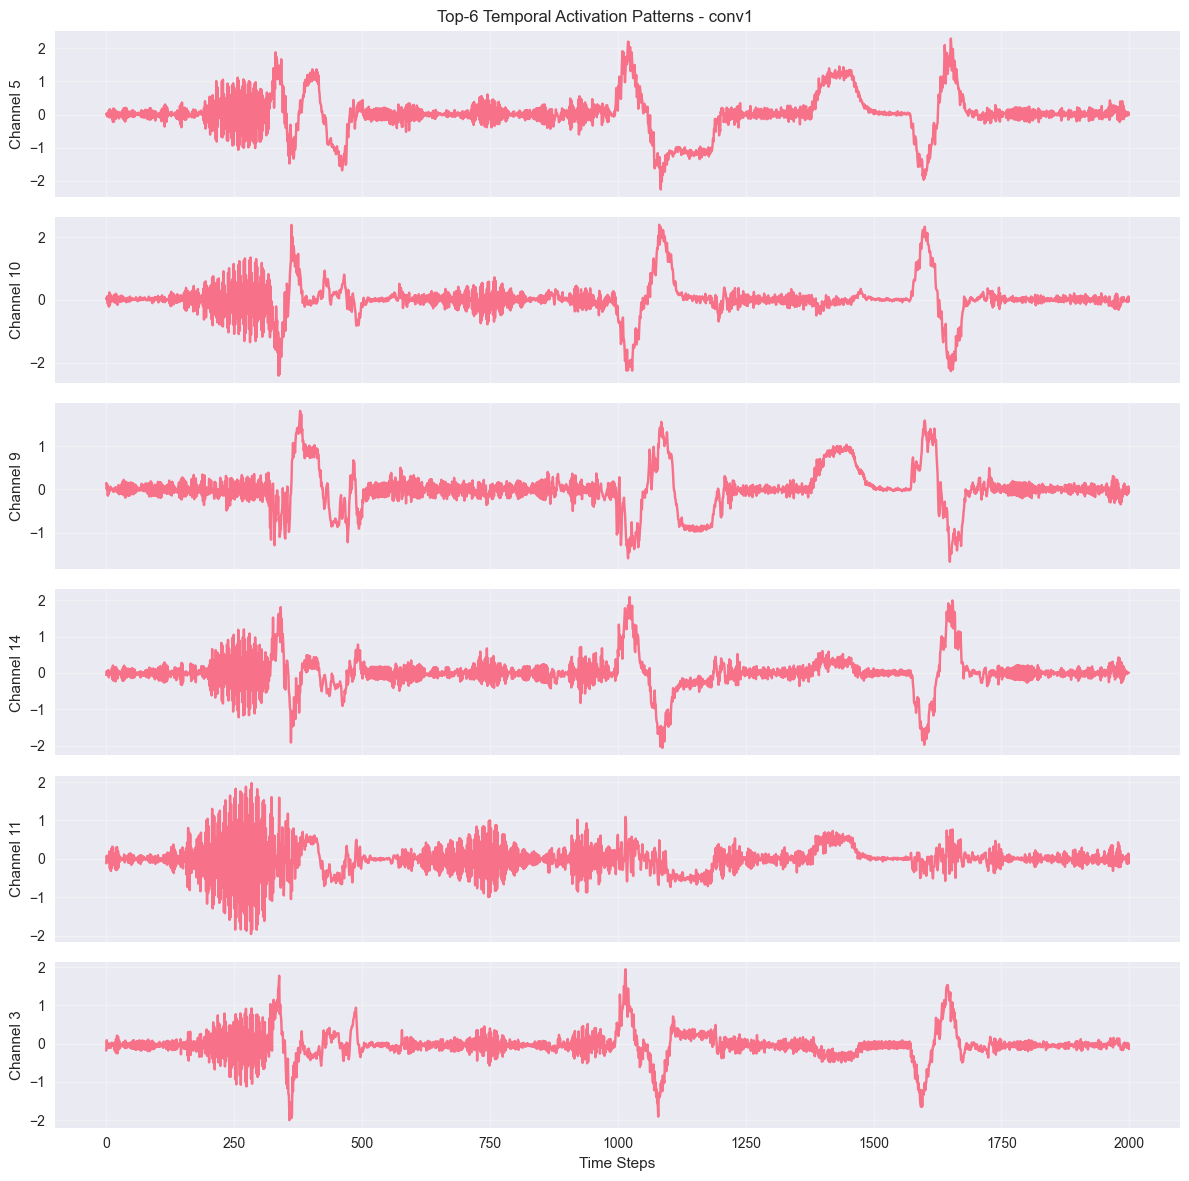

Channel 0 attribution shape: torch.Size([1, 16])
Channel 0 importance: 1.0000
Channel 1 attribution shape: torch.Size([1, 16])
Channel 1 importance: 1.0000
Channel 2 attribution shape: torch.Size([1, 16])
Channel 2 importance: 1.0000


In [25]:
# Analyze what activates each concept/channel
# Get activations and relevances from the recorded layer

if len(channel_results) > 0 and layer_to_analyze in channel_results[0].activations:
    # Get activations for the analyzed layer
    activations = channel_results[0].activations[layer_to_analyze]
    print(f"Activations shape: {activations.shape}")
    
    # Visualize activation patterns
    fig = visualize_temporal_concepts(activations, layer_to_analyze, top_k=6)
    plt.show()
    
    # Analyze channel importance
    concept = TimeSeriesConcept()
    
    for i, result in enumerate(channel_results[:3]):  # First 3 channels
        if layer_to_analyze in result.relevances:
            relevance = result.relevances[layer_to_analyze]
            channel_attribution = concept.attribute(relevance)
            
            print(f"Channel {channels_to_analyze[i]} attribution shape: {channel_attribution.shape}")
            print(f"Channel {channels_to_analyze[i]} importance: {channel_attribution[0].abs().sum().item():.4f}")
else:
    print("No activations recorded for the specified layer.")

## 7. Comparative Analysis: Good vs Bad Samples

In [26]:
# Get one good and one bad sample for comparison
good_indices = np.where(dataset.labels == 0)[0]
bad_indices = np.where(dataset.labels == 1)[0]

good_idx = good_indices[50]  # Choose a good sample
bad_idx = bad_indices[50]   # Choose a bad sample

good_data, good_label = dataset[good_idx]
bad_data, bad_label = dataset[bad_idx]

good_data = good_data.unsqueeze(0).to(device).requires_grad_(True)
bad_data = bad_data.unsqueeze(0).to(device).requires_grad_(True)

print(f"Good sample index: {good_idx}, Bad sample index: {bad_idx}")

Good sample index: 50, Bad sample index: 5656


In [27]:
# Compute predictions for both samples
with torch.no_grad():
    good_pred = model(good_data)
    bad_pred = model(bad_data)
    
    good_class = torch.argmax(good_pred, dim=1)
    bad_class = torch.argmax(bad_pred, dim=1)
    
    good_conf = torch.softmax(good_pred, dim=1)
    bad_conf = torch.softmax(bad_pred, dim=1)

print(f"Good sample - Predicted: {'Good' if good_class == 0 else 'Bad'}, Confidence: {good_conf[0, good_class]:.3f}")
print(f"Bad sample - Predicted: {'Good' if bad_class == 0 else 'Bad'}, Confidence: {bad_conf[0, bad_class]:.3f}")

TypeError: unsupported format string passed to Tensor.__format__

In [ ]:
# Compute attributions for both samples
composite = EpsilonGammaBox(low=-1, high=1, gamma=0.25)

good_conditions = [{'y': [good_class.item()]}]
bad_conditions = [{'y': [bad_class.item()]}]

good_result = attribution(good_data, good_conditions, composite)
bad_result = attribution(bad_data, bad_conditions, composite)

print("Comparative attribution computed!")

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(4, 1, figsize=(15, 16))

# Good sample
for ch in range(3):
    axes[0].plot(good_data[0, ch, :].cpu().detach().numpy(), 
                 color=colors[ch], alpha=0.7, label=f'Channel {channel_names[ch]}')
axes[0].set_title(f'Good Sample (Confidence: {good_conf[0, good_class]:.3f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Good sample attribution
good_heatmap = good_result.heatmap[0].cpu().detach().numpy()
axes[1].fill_between(range(len(good_heatmap)), 0, good_heatmap, 
                    alpha=0.7, color='green', label='Good Attribution')
axes[1].set_title('Good Sample Attribution')
axes[1].set_ylabel('Relevance')
axes[1].grid(True, alpha=0.3)

# Bad sample
for ch in range(3):
    axes[2].plot(bad_data[0, ch, :].cpu().detach().numpy(), 
                 color=colors[ch], alpha=0.7, label=f'Channel {channel_names[ch]}')
axes[2].set_title(f'Bad Sample (Confidence: {bad_conf[0, bad_class]:.3f})')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Bad sample attribution
bad_heatmap = bad_result.heatmap[0].cpu().detach().numpy()
axes[3].fill_between(range(len(bad_heatmap)), 0, bad_heatmap, 
                    alpha=0.7, color='red', label='Bad Attribution')
axes[3].set_title('Bad Sample Attribution')
axes[3].set_ylabel('Relevance')
axes[3].set_xlabel('Time Steps')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Summary and Insights

In [ ]:
# Analyze temporal patterns
def analyze_temporal_importance(heatmap, window_size=100):
    """Analyze which time windows are most important"""
    n_windows = len(heatmap) // window_size
    window_importance = []
    
    for i in range(n_windows):
        start_idx = i * window_size
        end_idx = (i + 1) * window_size
        window_rel = heatmap[start_idx:end_idx].sum()
        window_importance.append(window_rel)
    
    return np.array(window_importance)

# Analyze good vs bad temporal patterns
good_temporal = analyze_temporal_importance(good_heatmap)
bad_temporal = analyze_temporal_importance(bad_heatmap)

print("Temporal Analysis (per 100-step windows):")
print(f"Good sample - Most important window: {np.argmax(np.abs(good_temporal))} (relevance: {good_temporal[np.argmax(np.abs(good_temporal))]:.4f})")
print(f"Bad sample - Most important window: {np.argmax(np.abs(bad_temporal))} (relevance: {bad_temporal[np.argmax(np.abs(bad_temporal))]:.4f})")

# Plot temporal window analysis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

window_centers = np.arange(len(good_temporal)) * 100 + 50
ax1.bar(window_centers, good_temporal, width=80, alpha=0.7, color='green', label='Good Sample')
ax1.set_title('Temporal Window Importance - Good Sample')
ax1.set_ylabel('Relevance')
ax1.grid(True, alpha=0.3)

ax2.bar(window_centers, bad_temporal, width=80, alpha=0.7, color='red', label='Bad Sample')
ax2.set_title('Temporal Window Importance - Bad Sample')
ax2.set_xlabel('Time Steps (Window Center)')
ax2.set_ylabel('Relevance')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Insights

Based on the attribution analysis:

1. **Temporal Patterns**: The model focuses on specific time windows for classification
2. **Channel Importance**: Different vibration channels (X, Y, Z) may have varying importance
3. **Layer Concepts**: Early layers capture low-level temporal patterns, deeper layers capture more complex patterns
4. **Decision Differences**: Good and bad samples show different attribution patterns

This analysis helps understand:
- Which time segments are critical for fault detection
- How the model processes multi-channel vibration data
- What temporal features distinguish good from bad samples
- Whether the model's decisions align with domain knowledge